In [173]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [174]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-1 * other)

    def __neg__(self):
        return -1 * self

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, power, modulo=None):
        assert isinstance(power, (int, float)), "power must be int or float"
        out = Value(self.data ** power, (self,), '**')

        def _backward():
            self.grad += (power * self.data ** (power - 1)) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other ** -1

    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def tanh(self):
        n = self.data
        t = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [175]:
a = Value(2.0)
a - 1

Value(data=1.0)

In [176]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b;
e.label = 'e'
d = e + c;
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f;
L.label = 'L'

In [197]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge((str(id(n1))), str(id(n2)) + n2._op)
    dot.attr(width="2000pt", height="1800pt",fixedsize='true')
    return dot

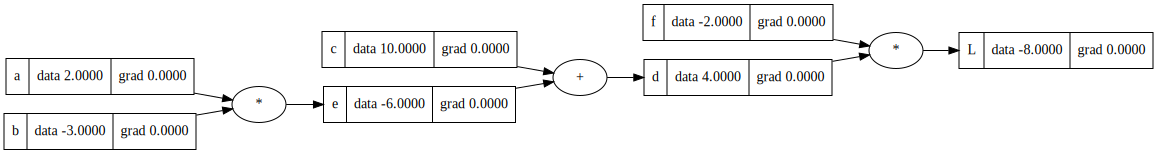

In [178]:
draw_dot(L)

In [179]:
# dL/df = d
f.grad = d.data
# dL/dd = f
d.grad = f.data

# dL/dc  dd/dc = 1 dd/de = 1  so dL/de = dL/dd * dd/de = f * 1 = f, this use chain rule
c.grad = f.data
e.grad = f.data

# dL/da = dd/da * dL/dd = b * f
a.grad = b.data * f.data
# dL/db = dd/db * dL/dd = a * f
b.grad = a.data * f.data


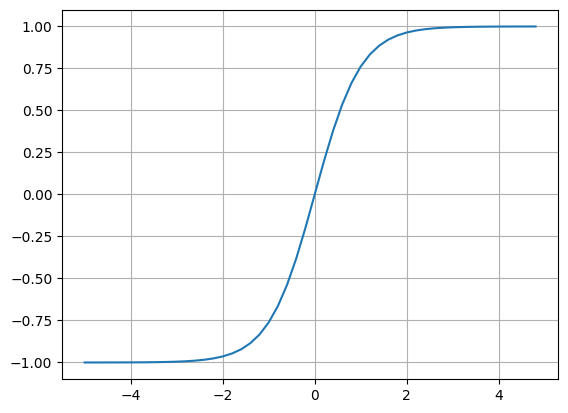

In [180]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)));
plt.grid()

In [181]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1;
x1w1.label = 'x1w1'
x2w2 = x2 * w2;
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2;
x1w1x2w2.label = 'x1w1 + x2w2'
z = x1w1x2w2 + b;
z.label = 'z'
o = z.tanh();
o.label = 'o'

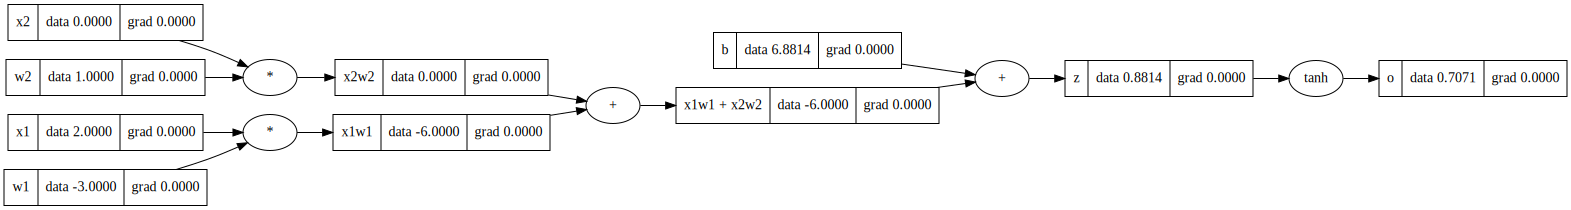

In [182]:
draw_dot(o)

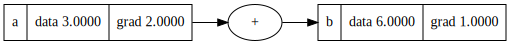

In [183]:
a = Value(3.0, label='a')
b = a + a;
b.label = 'b'
b.backward()
draw_dot(b)

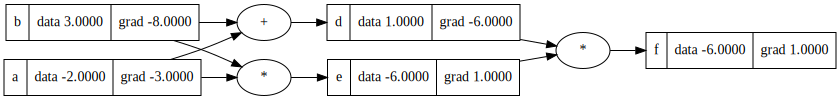

In [184]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a + b;
d.label = 'd'
e = a * b;
e.label = 'e'
f = d * e;
f.label = 'f'
f.backward()
draw_dot(f)

In [185]:
import torch

x1 = torch.tensor([2.0], requires_grad=True)
x2 = torch.tensor([0.0], requires_grad=True)
w1 = torch.tensor([-3.0], requires_grad=True)
w2 = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([6.8813735870195432], requires_grad=True)
z = x1 * w1 + x2 * w2 + b
o = torch.tanh(z)
print(o.item())
o.backward()

print('----')
print('x2', x2.grad.data.item())
print('x1', x1.grad.data.item())

0.7071067094802856
----
x2 0.5000001192092896
x1 -1.5000003576278687


In [186]:
w1.dtype

torch.float32

In [200]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1, 1))

    def __call__(self, x):
        act = sum(xi * wi for xi, wi in zip(x, self.w)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]


class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(sz) - 1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0]
n = MLP(2, [3, 1])
n(x)




Value(data=0.6773100484166396)

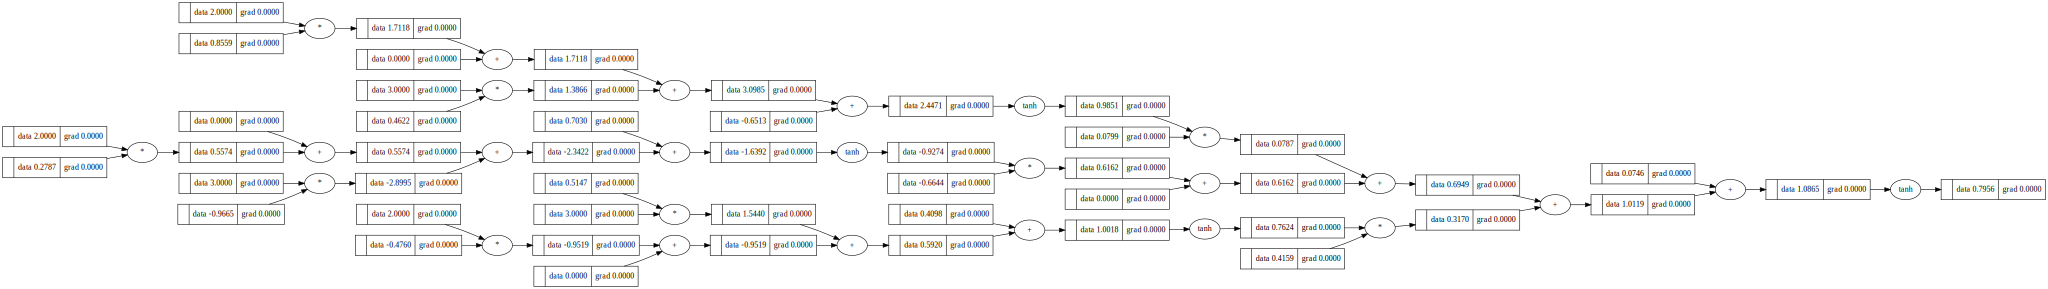

In [188]:
draw_dot(n(x))

In [206]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, 1.0, .5],
    [1.0, 1.0, -1.0],
]

ys = [
    1.0,
    -1.0,
    1.0,
]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9373602009188652),
 Value(data=0.8338724803134331),
 Value(data=0.8338724803134331)]

In [207]:
for k in range(10):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    loss.backward()
    
    # update  
    for p in n.parameters():
        p.data -= 0.01 * p.grad
    print(k, loss.data)

0 3.3946103712770785
1 3.365584275633405
2 3.2833212787081734
3 3.123398355786981
4 2.8430970240400355
5 2.418192941244233
6 2.0619083007474224
7 2.287773954616367
8 2.917550251389448
9 3.2800008591565435


In [193]:
loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
loss.backward()

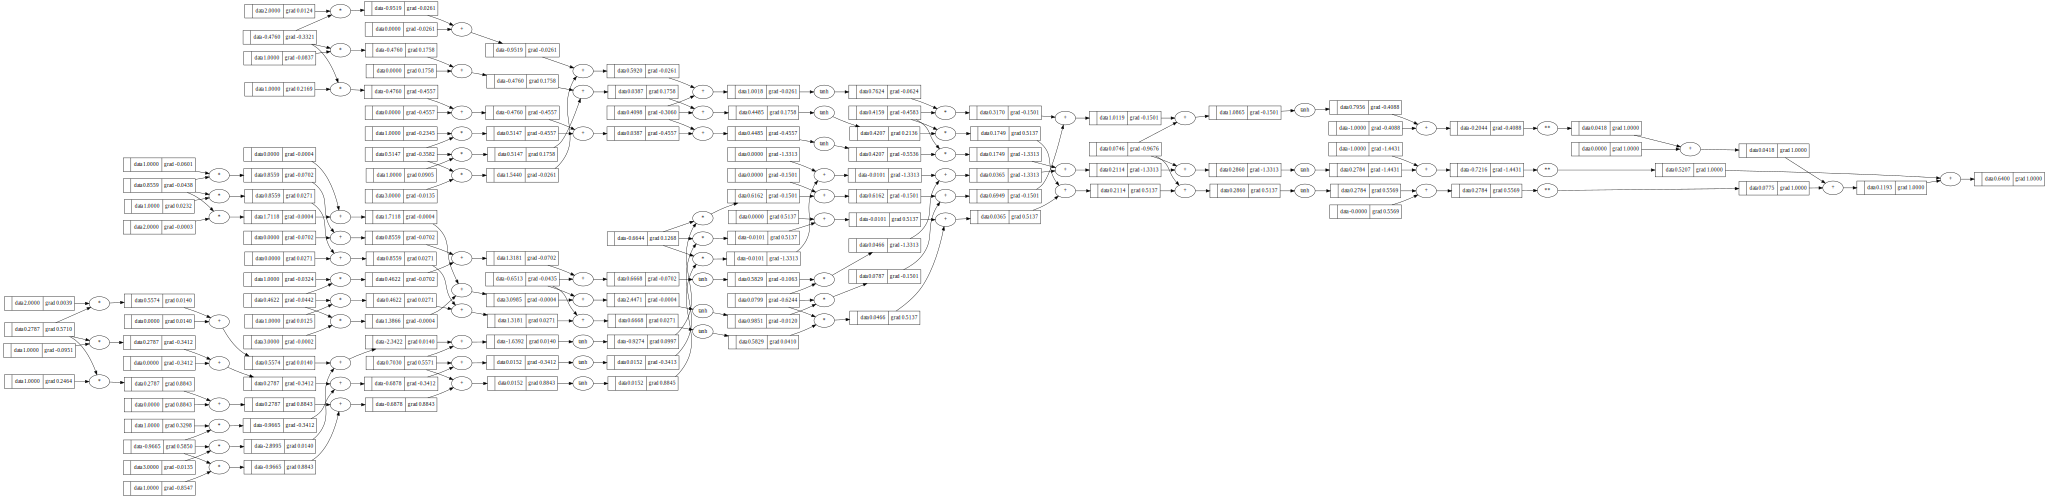

In [198]:
draw_dot(loss)